In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

import torch

from trace_process import *

TIME_DELTA = 500 * NANO_TO_MICRO
BATCH_SIZE = 32
MTU = 1514
WINDOW_SIZE = 10

/home/morteza/anaconda3/envs/torch-test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
total_recored = 3555634102
skip = 0
chunk = 200000000

df = pd.read_csv(
    "../data/11/node-2/train/packets", 
    sep='\t', 
    lineterminator='\n', 
    header=None,
    index_col=False,
    names=['timestamp', 'size', 'src', 'dest', 'dir'], 
    dtype={'size': "int16", 'src': "category", 'dest': "category", "timestamp": "int64", "size": "int64", "dir": "int8"},
    skiprows=skip,
    nrows=chunk
)
df = df[df['dir'] == 1][["timestamp", "size"]]
df = df.sort_values(by='timestamp')

In [3]:
trace = df.values
flow_packets, flow_times, flow_sizes, flows_span = get_flow_trace_time(trace, TIME_DELTA)
EM = np.median(flow_sizes)
flow_sizes_transformed = flow_sizes.reshape(-1, 1)
flow_sizes_transformed = preprocessing.MinMaxScaler().fit_transform(flow_sizes_transformed)
flow_sizes_transformed = flow_sizes_transformed.reshape(-1)
print("Number of flows: ", len(flow_sizes))
print("EM: ", EM)

/home/morteza/code/digger/morteza/trace_process.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flows_packets = np.array([value_trace[slice(*f)] for f in flows])
/home/morteza/code/digger/morteza/trace_process.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flow_times = np.array([time_stamp[slice(*f)] for f in flows])


Number of flows:  1149184
EM:  68526.0


In [4]:
labels = np.array([1.0 if f > EM else 0 for f in flow_sizes])
labels = np.roll(labels, -1)
labels = pd.DataFrame({'labels': labels})

In [5]:
dataset = pd.DataFrame({"flow": flow_sizes_transformed})
dataset_new = pd.DataFrame()
for i in range(WINDOW_SIZE + 1):
    dataset_new = pd.concat([dataset_new, dataset.shift(i, fill_value=0).rename(columns={'flow': f'flow{i}'})], axis=1) 

In [6]:
data_train, data_test, label_train, label_test = model_selection.train_test_split(dataset_new, labels, test_size=0.20, random_state=42)

In [7]:
model = xgboost.XGBClassifier()

In [8]:
model.fit(data_train, label_train)

/home/morteza/anaconda3/envs/torch-test/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/morteza/anaconda3/envs/torch-test/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/morteza/anaconda3/envs/torch-test/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

[15:58:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
pred = np.round(model.predict(data_test))

In [10]:
print("Accuracy is: ", metrics.accuracy_score(label_test, pred))

Accuracy is:  0.6514486353372172


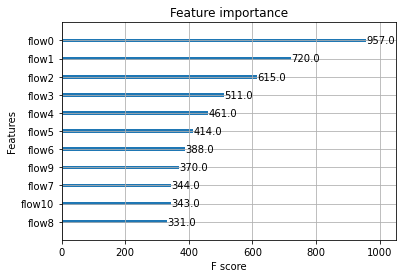

In [11]:
xgboost.plot_importance(model)
plt.show()